In [ ]:
# for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error, PredictionErrorDisplay
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Mount Drive, read file
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/aML/airbnb.csv')

Mounted at /content/drive


In [ ]:
# One-hot Encoding for city
df_encoded = pd.get_dummies(df, columns=['city'], prefix='city')

# Binary Encoding for time_period
df_encoded['is_weekend'] = (df_encoded['time_period'] == 'weekends').astype(int)

# Create combined stratification column
df_encoded['strat_column'] = df['city'] + '_' + df['time_period']

#Define features and target
X = df_encoded.drop(['price', 'log_price', 'time_period', 'strat_column'], axis=1)
y = df_encoded['log_price']

#Stratification split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_encoded['strat_column']
)

Definition Metrics:

In [ ]:
def get_metrics(y_true, y_pred):

    # MAE: the average of the absolute differences between the actual values and the predicted values
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE: the average absolute percentage difference between the actual and predicted values
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # MSE: the average of the squared differences between the actual values and the predicted values
    mse = mean_squared_error(y_true, y_pred)

    # RMSE: the square root of MSE
    rmse = np.sqrt(mse)

    # Max error: the average absolute percentage difference between the actual and predicted values
    max = max_error(y_true, y_pred)

    # return all four metrics
    return mae, mape, mse, rmse, max

Dummy Regressor

In [ ]:

dummy_regressor = DummyRegressor(strategy='mean')  # 'mean' predicts the average value in y_train
dummy_regressor.fit(X_train, y_train)

y_pred_dummy = dummy_regressor.predict(X_test)

r2_dummy = r2_score(y_test, y_pred_dummy)
r2_train_dummy = r2_score(y_train, dummy_regressor.predict(X_train))

dummy_model = dummy_regressor

print(f"Dummy Regressor Train R^2 Score: {r2_train_dummy:.4f}")
print(f"Dummy Regressor Test R^2 Score: {r2_dummy:.4f}")
dm_metrics = get_metrics(y_test, y_pred_dummy)
print("Dummy Regressor Metrics:")
print(dm_metrics)


Dummy Regressor Train R^2 Score: 0.0000
Dummy Regressor Test R^2 Score: -0.0002
Dummy Regressor Metrics:
(0.46630768512381326, 0.0860903672958136, 0.3556357545825101, 0.5963520391367083, 4.041425602719419)


Simple Linear Regressor

In [ ]:
lr = LinearRegression()


param_grid = {}

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

cv_r2 = grid_search.best_score_

best_lr = grid_search.best_estimator_

r2_train_lr = best_lr.score(X_train, y_train)
r2_test_lr = best_lr.score(X_test, y_test)

print(f"CV R² score: {cv_r2:.4f}")
print(f"Train R² score: {r2_train_lr:.4f}")
print(f"Test R² score: {r2_test_lr:.4f}")

lr_metrics = get_metrics(y_test, best_lr.predict(X_test))
print("Linear Regression Metrics:")
print(lr_metrics)

CV R² score: 0.6674
Train R² score: 0.6680
Test R² score: 0.6818
Linear Regression Metrics:
(0.25969367720579256, 0.047982341056005434, 0.11314440015983984, 0.3363694399909716, 2.9921926306570636)


Linear Regressor Polynomial Degrees

In [ ]:
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('lin_reg', LinearRegression())
])

param_grid = {}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

cv_r2 = grid_search.best_score_

best_poly = grid_search.best_estimator_

r2_train_poly = best_poly.score(X_train, y_train)
r2_test_poly  = best_poly.score(X_test, y_test)

print("Best parameters found: {'poly_features__degree': 2, "
      "'preprocessing__num__scaler': 'passthrough'}")
print(f"CV R² Score: {cv_r2:.4f}")
print(f"Train R² Score: {r2_train_poly:.4f}")
print(f"Test R² Score: {r2_test_poly:.4f}")

poly_metrics = get_metrics(y_test, best_poly.predict(X_test))
print("Polynomial Regression Metrics:")
print(poly_metrics)

Best parameters found: {'poly_features__degree': 2, 'preprocessing__num__scaler': 'passthrough'}
CV R² Score: 0.7179
Train R² Score: 0.7230
Test R² Score: 0.7279
Polynomial Regression Metrics:
(0.23815799534917942, 0.04403662306142843, 0.096743094984882, 0.3110355204552721, 1.9786232644976876)


Lasso Regression


In [ ]:
numeric_cols = [
    'person_capacity',
    'cleanliness_rating',
    'guest_satisfaction_overall',
    'city_dist',
    'metro_dist'
]

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3)),
    ('lasso_reg', Lasso(alpha=0.0001))
])

param_grid = {}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid_search.fit(X_train, y_train)

best_Lasso = grid_search.best_estimator_

cv_r2 = grid_search.best_score_

r2_train_lasso = best_Lasso.score(X_train, y_train)
r2_test_lasso  = best_Lasso.score(X_test, y_test)

print("Best parameters found: {'lasso_reg__alpha': 0.0001, 'poly_features__degree': 3, 'preprocessing__num__scaler': StandardScaler()'}")
print(f"CV R² Score: {cv_r2:.4f}")
print(f"Train R² Score: {r2_train_lasso:.4f}")
print(f"Test R² Score: {r2_test_lasso:.4f}")

lasso_metrics = get_metrics(y_test, best_Lasso.predict(X_test))
print("Lasso Regression Metrics:")
print(lasso_metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+03, tolerance: 1.457e+00
  model = cd_fast.enet_coordinate_descent(


Best parameters found: {'lasso_reg__alpha': 0.0001, 'poly_features__degree': 3, 'preprocessing__num__scaler': StandardScaler()'}
CV R² Score: 0.7268
Train R² Score: 0.7392
Test R² Score: 0.7400
Lasso Regression Metrics:
(0.2335263573060659, 0.04320900486766124, 0.09245225828343254, 0.3040596294864422, 1.79977524421039)


Ridge Regression

In [ ]:
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3, interaction_only=True)),
    ('ridge_reg', Ridge(alpha=50))
])

param_grid = {}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=3
)

grid_search.fit(X_train, y_train)

best_Ridge = grid_search.best_estimator_

cv_r2 = grid_search.best_score_

r2_train_ridge = best_Ridge.score(X_train, y_train)
r2_test_ridge  = best_Ridge.score(X_test, y_test)

# Print the results.
print("Best parameters found: {'poly_features__degree': 3, 'preprocessing__num__scaler': 'passthrough', 'ridge_reg__alpha': 50}")
print("Best parameters found:", grid_search.best_params_)
print(f"CV R² Score: {cv_r2:.4f}")
print(f"Train R² Score: {r2_train_ridge:.4f}")
print(f"Test R² Score: {r2_test_ridge:.4f}")

ridge_metrics = get_metrics(y_test, best_Ridge.predict(X_test))
print("Ridge Regression Metrics:")
print(ridge_metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {}
CV R² Score: 0.7174
Train R² Score: 0.7301
Test R² Score: 0.7283
Ridge Regression Metrics:
(0.23877643088165568, 0.04416323376136707, 0.09659838026758397, 0.31080279964566593, 1.9410522444763334)


KNN Regressor


In [ ]:
numerical_cols = ['person_capacity', 'cleanliness_rating',
                 'guest_satisfaction_overall', 'city_dist', 'metro_dist']

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(
        n_neighbors=9,
        p=1,
        weights='uniform'
    ))
])

param_grid = {}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

cv_r2 = grid_search.best_score_

best_knn = grid_search.best_estimator_

r2_train_knn = best_knn.score(X_train, y_train)
r2_test_knn  = best_knn.score(X_test, y_test)

print("Best parameters found: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform', 'preprocessor__num': StandardScaler()}")
print(f"CV R² Score: {cv_r2:.4f}")
print(f"Train R² Score: {r2_train_knn:.4f}")
print(f"Test R² Score: {r2_test_knn:.4f}")

knn_metrics = get_metrics(y_test, best_knn.predict(X_test))
print("KNN Metrics:")
print(knn_metrics)

CV R² Score: 0.6835
Train R² Score: 0.7559
Test R² Score: 0.7043
KNN Metrics:
(0.24185584303158453, 0.0445344057769588, 0.10512835885047388, 0.3242350364326377, 3.926089717550515)


Random Forest Regressor

In [ ]:
numerical_cols = ['person_capacity', 'cleanliness_rating',
                 'guest_satisfaction_overall', 'city_dist', 'metro_dist']

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200
    ))
])

param_grid = {}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

cv_r2 = grid_search.best_score_

best_forest = grid_search.best_estimator_

r2_train_forest = best_forest.score(X_train, y_train)
r2_test_forest = best_forest.score(X_test, y_test)

print("Best parameters found: {'preprocessor__num': StandardScaler(), 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}")
print(f"CV R² Score: {cv_r2:.4f}")
print(f"Train R² Score: {r2_train_forest:.4f}")
print(f"Test R² Score: {r2_test_forest:.4f}")

forest_metrics = get_metrics(y_test, best_forest.predict(X_test))
print("Random Forest Metrics:")
print(forest_metrics)

Best parameters found: {'preprocessor__num': StandardScaler(), 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
CV R² Score: 0.8177
Train R² Score: 0.9782
Test R² Score: 0.8504
Random Forest Metrics:
(0.16594050449988829, 0.030773838203796953, 0.053180377163060163, 0.23060871007631123, 1.5661298478177024)


Evaluation Matrix

In [ ]:
# create a dataframe (table) to store and display the computed metrics where each row represents a different model and each column represents a different metric
results = pd.DataFrame({
    'Model': ['Dummy', 'Simple Linear Regression', 'Polynomial Degrees', 'Lasso', 'Ridge', 'KNN Regressor', 'Random Forest'],  # model names
    'Train R^2':[r2_train_dummy, r2_train_lr, r2_train_poly, r2_train_lasso, r2_train_ridge, r2_train_knn, r2_train_forest],  # Train R^2 values for each model
    'Test R^2': [r2_dummy, r2_test_lr, r2_test_poly, r2_test_lasso, r2_test_ridge, r2_test_knn, r2_test_forest],  # Test R^2 values for each model
    'MAE': [dm_metrics[0], lr_metrics[0], poly_metrics[0], lasso_metrics[0], ridge_metrics[0], knn_metrics[0], forest_metrics[0]],  # MAE values for each model
    'MAPE': [dm_metrics[1], lr_metrics[1], poly_metrics[1], lasso_metrics[1], ridge_metrics[1], knn_metrics[1], forest_metrics[1]],  # MAPE values for each model
    'MSE': [dm_metrics[2], lr_metrics[2], poly_metrics[2], lasso_metrics[2], ridge_metrics[2], knn_metrics[2], forest_metrics[2]],  # MSE values for each model
    'RMSE': [dm_metrics[3], lr_metrics[3], poly_metrics[3], lasso_metrics[3], ridge_metrics[3], knn_metrics[3], forest_metrics[3]], # RMSE values for each model
    'Max': [dm_metrics[4], lr_metrics[4], poly_metrics[4], lasso_metrics[4], ridge_metrics[4], knn_metrics[4], forest_metrics[4]] # Max error values for each model

})

results

Model  Train R^2  Test R^2       MAE      MAPE  \
0                     Dummy   0.000000 -0.000236  0.466308  0.086090   
1  Simple Linear Regression   0.668012  0.681778  0.259694  0.047982   
2        Polynomial Degrees   0.723033  0.727907  0.238158  0.044037   
3                     Lasso   0.739210  0.739975  0.233526  0.043209   
4                     Ridge   0.730100  0.728314  0.238776  0.044163   
5             KNN Regressor   0.755922  0.704323  0.241856  0.044534   
6             Random Forest   0.978128  0.851198  0.165342  0.030650   

        MSE      RMSE       Max  
0  0.355636  0.596352  4.041426  
1  0.113144  0.336369  2.992193  
2  0.096743  0.311036  1.978623  
3  0.092452  0.304060  1.799775  
4  0.096598  0.310803  1.941052  
5  0.105128  0.324235  3.926090  
6  0.052907  0.230015  1.543246

<ipython-input-22-b3a19c4d8664>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Test R^2', y='Model', palette=palette)


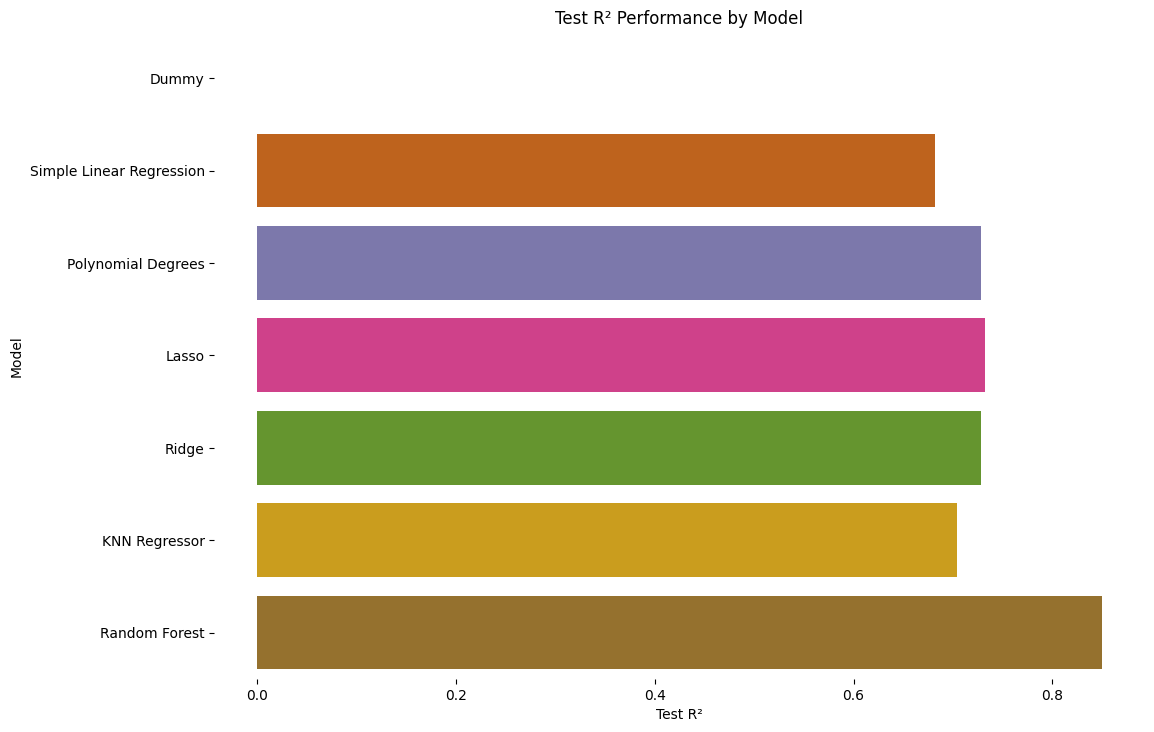

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

num_models = results['Model'].nunique()
figsize = (12, 1.2 * num_models)
plt.figure(figsize=figsize)

palette = sns.color_palette("Dark2", num_models)

sns.barplot(data=results, x='Test R^2', y='Model', palette=palette)

sns.despine(top=True, right=True, bottom=True, left=True)

plt.title('Test R² Performance by Model')
plt.xlabel('Test R²')
plt.ylabel('Model')

plt.show()


Random Forest plot - actual vs predicted

Test Data R² Score: 0.8512


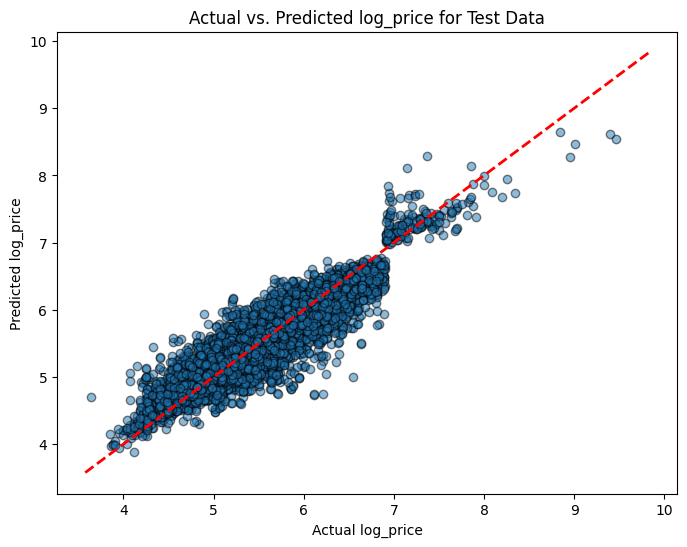

In [ ]:
y_pred_test = best_forest.predict(X_test)
r2_test = best_forest.score(X_test, y_test)
print(f"Test Data R² Score: {r2_test:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual log_price")
plt.ylabel("Predicted log_price")
plt.title("Actual vs. Predicted log_price for Test Data")
plt.show()


Lasso plot - actual vs predicted

Test Data R² Score: 0.7400


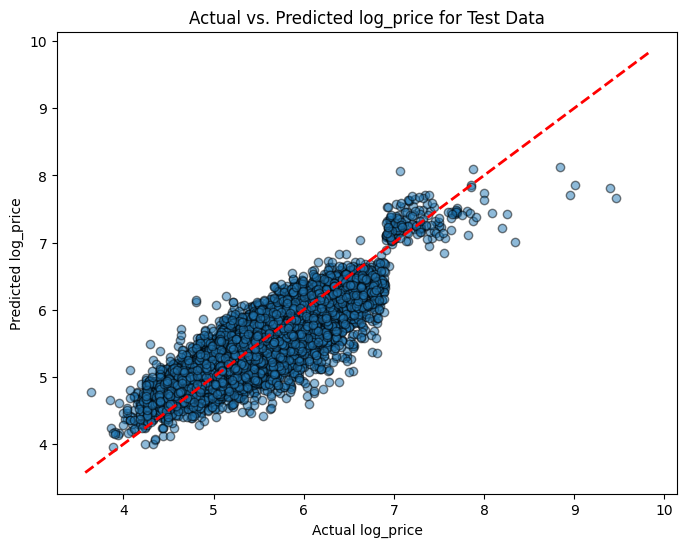

In [ ]:
y_pred_test = best_Lasso.predict(X_test)
r2_test = best_Lasso.score(X_test, y_test)
print(f"Test Data R² Score: {r2_test:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual log_price")
plt.ylabel("Predicted log_price")
plt.title("Actual vs. Predicted log_price for Test Data")
plt.show()


Testing  Best_Forest Regressor and best_Lasso Regressor

In [ ]:
feature_names = [
    'room_shared',                # boolean
    'room_private',               # boolean
    'person_capacity',            # int
    'host_is_superhost',          # boolean
    'multipleRooms',              # boolean
    'businessListing',            # boolean
    'cleanliness_rating',         # int
    'guest_satisfaction_overall', # int
    'city_dist',                  # float
    'metro_dist',                 # float
    'entire_home',                # boolean
    'is_luxury',                  # boolean
    'is_weekend',                 # int
    'city_amsterdam',             # boolean
    'city_athens',                # boolean
    'city_barcelona',             # boolean
    'city_berlin',                # boolean
    'city_budapest',              # boolean
    'city_lisbon',                # boolean
    'city_london',                # boolean
    'city_paris',                 # boolean
    'city_rome',                  # boolean
    'city_vienna'                 # boolean
]

apartment_data = {
    'room_shared': [False],                # not a shared room
    'room_private': [True],                # it's a private roomt
    'person_capacity': [3],                # can accommodate 3 persons
    'host_is_superhost': [True],           # the host is a superhost
    'multipleRooms': [False],              # it's not spread across multiple rooms
    'businessListing': [False],            # not a business listing
    'cleanliness_rating': [9],             # high cleanliness rating
    'guest_satisfaction_overall': [90],    # high guest satisfaction
    'city_dist': [2.5],                    # distance to city center in km
    'metro_dist': [0.5],                   # distance to metro station in km
    'entire_home': [True],                 # it's the entire home
    'is_luxury': [False],                  # not a luxury listing
    'is_weekend': [0],                     # 0 indicates not a weekend listing
    'city_amsterdam': [False],
    'city_athens': [False],
    'city_barcelona': [False],
    'city_berlin': [False],
    'city_budapest': [False],
    'city_lisbon': [False],
    'city_london': [True],                 # apartment is in London
    'city_paris': [False],
    'city_rome': [False],
    'city_vienna': [False]
}


apartment_df = pd.DataFrame(apartment_data, columns=feature_names)
apartment_df = apartment_df[X_train.columns]

predicted_log_price_forest = best_forest.predict(apartment_df)[0]
predicted_price_forest = np.exp(predicted_log_price_forest)
print(f"Predicted price for the apartment in London using Random Forrest Regression: {predicted_price_forest:.2f}")

predicted_log_price_lasso = best_Lasso.predict(apartment_df)[0]
predicted_price_lasso = np.exp(predicted_log_price_lasso)

print(f"Predicted price for the apartment in London using Lasso Regression: {predicted_price_lasso:.2f}")

Predicted price for the apartment in London using Random Forrest Regression: 495.56
Predicted price for the apartment in London using Lasso Regression: 417.10


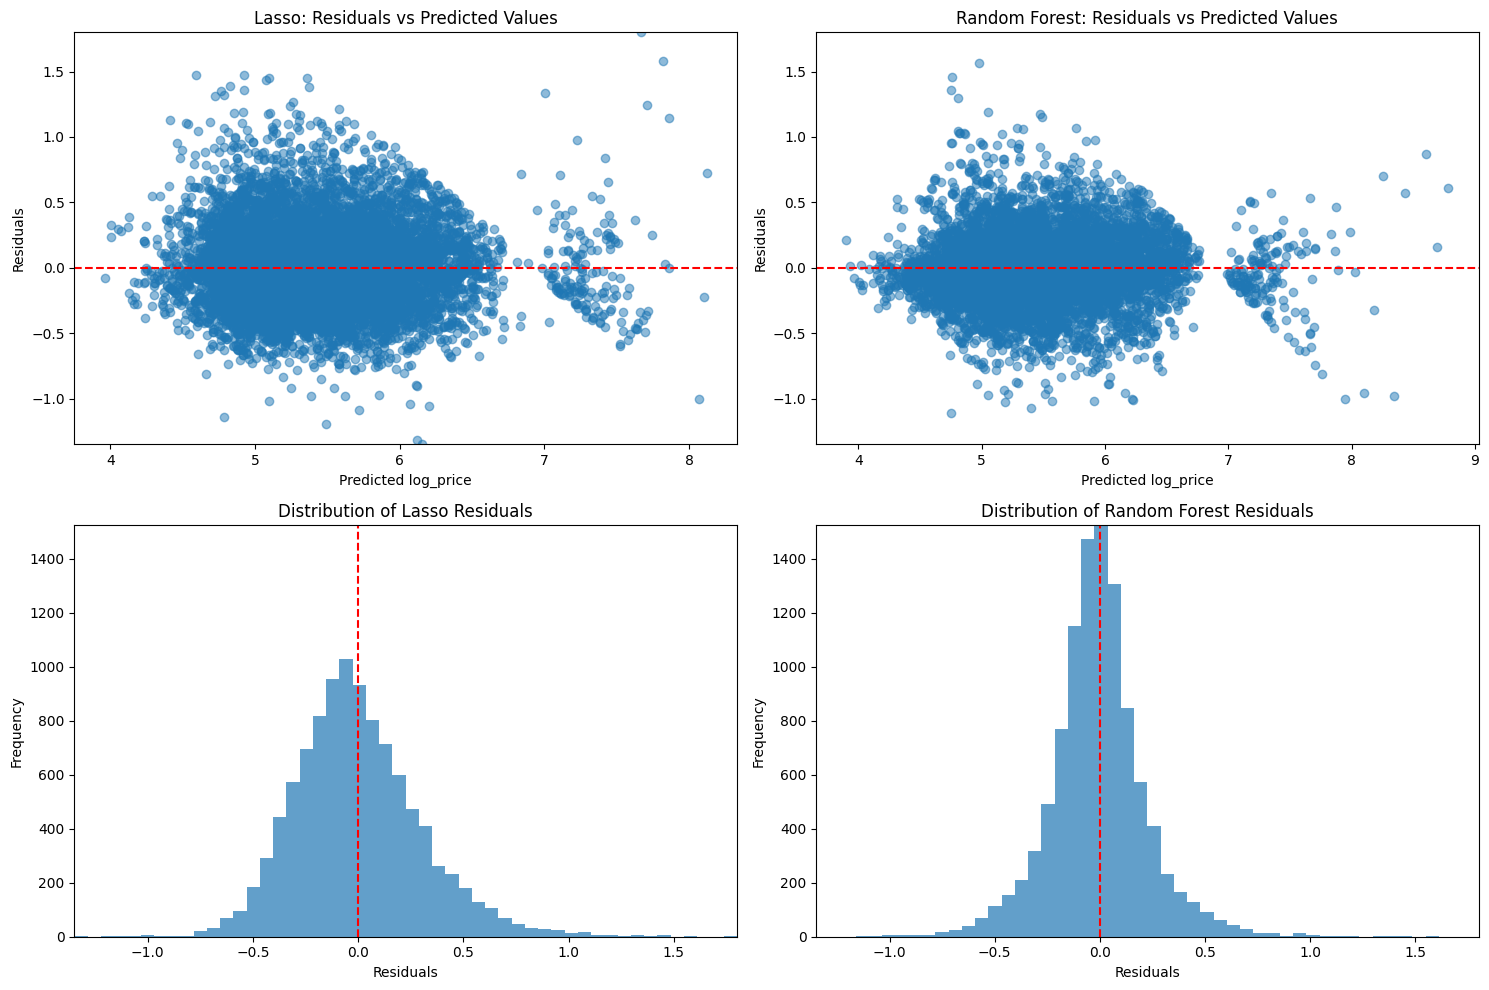

In [ ]:
y_pred_lasso = best_Lasso.predict(X_test)
y_pred_rf = best_forest.predict(X_test)

residuals_lasso = y_test - y_pred_lasso
residuals_rf = y_test - y_pred_rf

global_residual_min = min(residuals_lasso.min(), residuals_rf.min())
global_residual_max = max(residuals_lasso.max(), residuals_rf.max())

n_bins = 50
bin_edges = np.linspace(global_residual_min, global_residual_max, n_bins + 1)

counts_lasso, _ = np.histogram(residuals_lasso, bins=bin_edges)
counts_rf, _ = np.histogram(residuals_rf, bins=bin_edges)
max_freq = max(counts_lasso.max(), counts_rf.max())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Lasso Residuals vs Predicted Values
ax1.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted log_price')
ax1.set_ylabel('Residuals')
ax1.set_title('Lasso: Residuals vs Predicted Values')
ax1.set_ylim(global_residual_min, global_residual_max)

# Random Forest Residuals vs Predicted Values
ax2.scatter(y_pred_rf, residuals_rf, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted log_price')
ax2.set_ylabel('Residuals')
ax2.set_title('Random Forest: Residuals vs Predicted Values')
ax2.set_ylim(global_residual_min, global_residual_max)

# Histogram of Lasso Residuals
ax3.hist(residuals_lasso, bins=bin_edges, alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Lasso Residuals')
ax3.set_xlim(global_residual_min, global_residual_max)
ax3.set_ylim(0, max_freq)

# Histogram of Random Forest Residuals
ax4.hist(residuals_rf, bins=bin_edges, alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Random Forest Residuals')
ax4.set_xlim(global_residual_min, global_residual_max)
ax4.set_ylim(0, max_freq)

plt.tight_layout()